# Response and Resolution Studies for the Trigger Level Analysis at the ATLAS Experiment

## Abstract
When particles collide at the Large Hadron Collider, the invariant mass of new particles can be derived by detecting their decay products. The Trigger Level Analysis at the ATLAS experiment uses partly reconstructed particle collision events for its analysis. The smaller data size allows the Trigger Level Analysis to obtain a much larger number of events and a smaller statistical uncertainty. This notebook presents the data processing and analysis used to plot the invariant mass response. The response is the ratio of invariant mass as determined by particles simulated to interact with the detector, divided by the invariant mass as determined by the same particles, without interaction with the detector. Doing this after each step of the Trigger Level Analysis calibration allows us to see if any calibration step introduces signal-like features in the analysis. The insights gained from the response studies are also used to estimate the invariant mass resolution of the analysis and with that derive an optimal histogram binning.

## Introduction
### Jets
When particles collide at the Large Hadron Collider (LHC) at CERN, it is possible that new particles are created and these particles decay into decay products. The ATLAS detector allows us to study these decay products and learn about the properties of the original particle. Due to the nature of the strong force, one of the most common observable objects at ATLAS are collimated particle showers. From the detector data, we can then group the energy deposits of these particle showers into an object called a jet. By studying these jets we can learn about particles created in the collision, such as the Higgs boson.

![alt text](images/jets.png "Title")

### Invariant Mass and Response
Particle collision event data at the LHC uses a specialized data framework and file format called ROOT. We can for each particle collision event access, among other things, the jet's energy and momentum (including direction in the cylindrical coordinates $\eta$ (eta) and $\phi$ (phi)). With this, we can represent the jets as [four-vectors](https://en.wikipedia.org/wiki/Four-vector) and calculate the di-jet [invariant mass](https://en.wikipedia.org/wiki/Invariant_mass) ($m_{jj}$) of the particle formed by the collision.

Before we run the following notebook, a C++ algorithm has processed millions of simulated particle collision events from Monte Carlo (MC) simulation. With simulated events we can look at the energy and momentum of particles and jets as they would look purely theoretically, we call these jets "truth jets". We can also simulate each particle's propagation and interaction with the detector and its final digital readout. This gives us what we call "reconstructed jets".

Since truth jets only exist in simulation, the simulations allow us to look at the invariant mass ratio between the reconstructed jets and truth jets, which we call response. 

$$ R = \frac{m_{jj_{Reco}}}{m_{jj_{Truth}}} $$

This response gives us an idea of how much jets measured in reality (reconstructed jets), differ from the truth jets. This in turn gives us important information about the detector, calibration, and data processing.

### Jet Calibration
Apart from calibration of the individual detector components at ATLAS, we use an MC-driven calibration where we derive different calibration constants and curves by comparing reconstructed objects to truth objects. After the full calibration we want the difference betwee recotnructed an truth jets to be 0, i.e the response to be 1. The figure below shows the Trigger Level Analysis (TLA) calibration steps. Where the final step corrects for disagreement between the MC simulations and actual data.

![alt text](images/calibration.png "Title")

Each calibration step above brings our jets to a different "energy scale": EM, Pileup, ETaJES, GSC, in-situ. In this notebook, we will look at the $m_{jj}$ response as a function of the true $m_{jj}$ for the first four energy scales in different slices of the spatial dimension $\eta$. By looking at the response at each energy scale we can see if any step of the calibration introduces any bumps or features, which would interfere with our final analysis looking for new particles.

### Invariant Mass Resolution and Binning
Since the $m_{jj}$ distribution is the main observable for TLA in the search for new physics, it is important to use a suitable histogram binning. There are two conflicting considerations in deriving this binning.
1. Bins should be wider than the detector resolution to limit the effect from event migrations between bins.
2. A narrow binning allows a possible signal excess to spread over multiple bins, allowing for multiple inputs to a fit.

The binning is derived by an estimated detector resolution, which we define as the standard deviation of the fitted $m_{jj}$ response distribution at a given truth $m_{jj}$.

### Data Processing in this Notebook
A root file, with a unique root file path, is distinguished by being from a different campaign (mc16a or mc16d), and being made from different objects (Online jets or Offline jets). For example, in directory v14 we have one root file from the mc16d campaign with online jets. Directory v19 is mc16a with offline jets.

The C++ algorithm, which was run before this notebook, creates 3D histograms with $m_{jj}$ response, truth $m_{jj}$, and truth $\eta$ on the x, y, and z-axis respectively. Each root file contains one 3D histgoram per energy scale in the calibration. This notebook transforms these 3D histograms into more understandable plots such as $m_{jj}$ response vs truth $m_{jj}$ using the following steps:

#### Fitting
* 3D histograms (called "TH3" or "h3D" in the code) are sliced on the z-axis and projected into a 2D histogram (each slice is typically in truth $\eta$).
![alt text](images/3d_to_2d.png "Title")
* 2D histograms (called "h2D" in the code) are sliced in bins on the y axis and projected into 1D histograms (each slice is typically a truth $m_{jj}$ bin).
![alt text](images/2d_to_1d.png "Title")
* 1D histograms (called "h1D" in the code) are fitted with a gaussian using an external python script called "JESBalanceFitter".
* Information about the gaussian fits are written into a list of the data series in the dataframe for that $\eta$ slice.

For example, this means that for the mc16d Online ROOT file, we create one pandas data frame per $\eta$ slice. In the $\eta$=[-2.8,2.8] slice data frame we store information about the fitted 1D histograms for each 3D histogram as it's own data series, with the 3D histogram name as index.

#### Plotting
* For each $\eta$ slice a data frame is read into memory.
* For each 3D Histogram in that dataframe, a set of the available fit information is read into memory.
* For each 3D histogram, the fit mean is plotted at the corresponding 2D histograms $m_{jj}$ truth bin center. This gives an $m_{jj}$ response vs truth $m_{jj}$ plot for all 3D histograms, for all $\eta$ slices.
![alt text](images/1d_to_graph.png "Title")

### Final Notes
Sometimes we would like to look at a quantity called "transverse momentum" (pT) alongside $m_{jj}$, it would be treated the same as $m_{jj}$ in the data processing. For simplicity we only look at $m_{jj}$ here.

## Response
### Fitting
We start by importing the necessary packages. When running this cell, ROOT will ouput a lot of runtime warnings. As long as the last output says `Welcome to JupyROOT 6.20/00` we are fine.

In [10]:
import ROOT
from JES_BalanceFitter import JES_BalanceFitter
import numpy as np
import pandas as pd
import pickle

Set the base path to be independent of the directory path and define the paths to the different data sets.

In [11]:
pathList=!pwd
path=pathList[0]
listOfRootFilePaths = [path+"/response_calibMay2024_data_J100_2017.root",
                      ]

Create a directory to house all the output plots. You can go here to find the plots in PDF format.

In [12]:
!mkdir output

mkdir: output: File exists


Set parameters for the slicing and projecting.

In [13]:
slicingAxis = "z"
slices = [[-2.8,2.8]]
currentSlice = slices[0]

projectionAxis = "y"
projectionRebinWidth = 2

responseAxis = "x"

Set parameters for the gaussian fit.

In [14]:
nSigmaForFit = 1.3
fitOptString = "RESQ"

In the following, we will loop for each file path, for each slice in $\eta$. Where we first create an empty dataframe for that slice, with one data series for each 3D histogram (one per energy scale). For each 3D histogram we slice, project, and fit the response and save the fit variables to the dataframe data series. With the 3D histogram name as index. This means that for each file path we will get as many response plots as we have $\eta$ slices, and in each plot we will have as many data series as we have energy scales.

In [15]:
# Open the file
inFile = ROOT.TFile.Open(listOfRootFilePaths[0]) # Open root file containing 3D histograms

This is to check what's in the file - there will be many more histograms than we need for this first test, we will pick the one called *h_HLT_j420_-_InsituUnprescaled-Online_over_InsituUnprescaled-Offline_-_mjj_-_etaLeading*. The important naming convention is in the last two parts, as this what the axes are. So for this histogram:
   * x axis: response (for trigger jets over offline jets, it's just an example)
   * y axis: dijet invariant mass bins
   * z axis: eta of the leading jet

In [16]:
inFile.ls()

TFile**		/Users/user/iCloudDrive/Work/2025_SingleParticleJES/202502_Notebook/Debugging_Zhicheng/responseStudies-basic-JESSingleParticle/response_calibMay2024_data_J100_2017.root	
 TFile*		/Users/user/iCloudDrive/Work/2025_SingleParticleJES/202502_Notebook/Debugging_Zhicheng/responseStudies-basic-JESSingleParticle/response_calibMay2024_data_J100_2017.root	
  KEY: TTree	EventLoop_FileExecuted;1	executed files
  KEY: TTree	EventLoop_JobStats;1	EventLoop job statistics
  KEY: TH2F	hh_matchIndex;1	hh_matchIndex
  KEY: TH1F	hh_matchEff;1	hh_matchEff
  KEY: TProfile2D	hhProfile_ptProbe_ptAvg_etaRef;1	Profile of ptProbe vs (ptAvg and etaRef)
  KEY: TProfile2D	hhProfile_etaProbe_ptAvg_etaRef;1	Profile of etaProbe vs (ptAvg and etaRef)
  KEY: TH3D	h_HLT_j110_-_InsituUnprescaled-Online_over_InsituUnprescaled-Offline_-_mjj_-_etaLeading;1	h_HLT_j110_-_InsituUnprescaled-Online_over_InsituUnprescaled-Offline_-_mjj_-_etaLeading
  KEY: TH3D	h_HLT_j110_-_OnlineToOfflineUnprescaled-Online_over_OnlineToOf

Now define the fit parameters for this histogram keyed by histogram name, using a pandas series (we could have used a dictionary, but this will be useful later)

In [17]:
fitParametersDictionary = []
fitParametersDictionary.append(pd.Series({
                                     "x"             :[],
                                     "y"             :[],
                                     "xError"        :[],
                                     "yError"        :[],
                                     "sigma"         :[],
                                     "sigmaError"    :[],
                                     "sigmaOverY"    :[],
                                     "sigmaOverYError"    :[],
                                     "fitAmplitude"  :[],
                                     "fitMin"        :[],
                                     "fitMax"        :[],

                                     "TH1BinEdges"   :[],
                                     "TH1BinEntries" :[],
                                     "TH1BinErrors"  :[],
                                   },
                                      name="h_HLT_j420_-_InsituUnprescaled-Online_over_InsituUnprescaled-Offline_-_mjj_-_etaLeading"))

In [18]:
df = pd.DataFrame(fitParametersDictionary) # Create the dataframe form the dictionary list
print(df)

                                                     x   y xError yError  \
h_HLT_j420_-_InsituUnprescaled-Online_over_Insi...  []  []     []     []   

                                                   sigma sigmaError  \
h_HLT_j420_-_InsituUnprescaled-Online_over_Insi...    []         []   

                                                   sigmaOverY sigmaOverYError  \
h_HLT_j420_-_InsituUnprescaled-Online_over_Insi...         []              []   

                                                   fitAmplitude fitMin fitMax  \
h_HLT_j420_-_InsituUnprescaled-Online_over_Insi...           []     []     []   

                                                   TH1BinEdges TH1BinEntries  \
h_HLT_j420_-_InsituUnprescaled-Online_over_Insi...          []            []   

                                                   TH1BinErrors  
h_HLT_j420_-_InsituUnprescaled-Online_over_Insi...           []  


Now get the histogram from the file, and check that it can be read by printing its content

In [19]:
for TH3Name in df.index:
    #print(TH3Name)
    inTH3 = inFile.Get(TH3Name) # Retreive the current 3D histogram form the root file
    h3D = inTH3.Clone() # Clone it ot keep it intact
    h3D.Print()

TH1.Print Name  = h_HLT_j420_-_InsituUnprescaled-Online_over_InsituUnprescaled-Offline_-_mjj_-_etaLeading, Entries= 3001173, Total sum= 2.99606e+06


Configure the fitter and the fit ranges

In [20]:
#Set fitting options for the JES_BalanceFitter tool
JESBfitter = JES_BalanceFitter(nSigmaForFit)
JESBfitter.SetGaus()
JESBfitter.SetFitOpt(fitOptString)

# Set the 3D histogram range to correspond to the desired slice range
if slicingAxis == "y":
    h3D.GetYaxis().SetRangeUser(currentSlice[0], currentSlice[1])     
elif slicingAxis == "z":
    h3D.GetZaxis().SetRangeUser(currentSlice[0], currentSlice[1]) 

# Project the 3D histogram with the sliced axis range into a 2D histogram
h2D=h3D.Project3D(responseAxis + projectionAxis)

# Rebin the 2D histogram x-axis according to the desired rebinningFactor
h2D.RebinX(projectionRebinWidth)

Let's have a look at the 2D histogram, using ROOT's native plotting. CD TODO: not sure why it doesn't display on screen, but it looks OK in the image saved in the folder

In [21]:
%jsroot on

In [22]:
c1 = ROOT.TCanvas ("c1", "TestCanvas", 900, 400)
c1.cd()
h2D.Draw("COLZ")
c1.Print("test.png")

Info in <TCanvas::Print>: png file test.png has been created


Now do the fit

In [23]:
# Loop over the bins in the 2D histogram x-axis
for currentRebinnedBin in range(1, h2D.GetNbinsX()+1): # Histograms start at bin 1, plus one to include last bin
    # Name of the 1D projection
    projName = "slice"+str(currentSlice[0])+"to"+str(currentSlice[1])+"_projectionBin"+str(h2D.GetXaxis().GetBinLowEdge(currentRebinnedBin))+"to"+str(h2D.GetXaxis().GetBinUpEdge(currentRebinnedBin))

    # Project the current 2D histogram bin into a 1D histogram
    h1D=h2D.ProjectionY(projName, currentRebinnedBin, currentRebinnedBin)

    # If the current 2D bin is empty skip it
    if h1D.GetEntries() == 0:
        #print("empty 1D hist, skipping!")
        continue

    # Set the fit limits based on the 1D histogram properties
    fitMax = h1D.GetMean() + nSigmaForFit * h1D.GetRMS()
    fitMin = h1D.GetMean() - nSigmaForFit * h1D.GetRMS()

    # Obtain fit using JES_BalanceFitter           
    JESBfitter.Fit(h1D, fitMin, fitMax)
    fit = JESBfitter.GetFit()
    histFit = JESBfitter.GetHisto()
    Chi2Ndof = JESBfitter.GetChi2Ndof()

    # Initialize empty lists to hold the values of each 1D histogram.
    # There will be as many 1D histograms as Y axis bins of the 3D histogram
    binEdges=[]
    binEntries=[]
    binErrors=[]

    # Loop over the response bins in the 1D histogram
    for i in range(1, h1D.GetNbinsX()+1):# Plus one to include last bin
      binEdges.append(h1D.GetXaxis().GetBinLowEdge(i)) # Get the current bin edge for plotting later
      binEntries.append(h1D.GetBinContent(i)) # Get the number of entries in the bin for plotting later
      binErrors.append(h1D.GetBinError(i)) # Get the bin error to get the width of the bin... For plotting later
    binEdges.append(h1D.GetXaxis().GetBinUpEdge(h1D.GetNbinsX()))# Append the right most edge of the last bin

    # Append all the lists for this 1D histogram to the list of lists in the dataframe.
    # One dataframe per slice, per root file path

    # Append all the values of the 1D histogram gaussian fit to the lists of the current data frame series
    # There are ~4 series per data frame, 1 dataframe per slice, per root file path
    df["x"].loc[TH3Name].append(float(h2D.GetXaxis().GetBinCenter(currentRebinnedBin)))
    df["y"].loc[TH3Name].append(float(fit.GetParameter(1)))
    df["xError"].loc[TH3Name].append(float((h2D.GetXaxis().GetBinWidth(currentRebinnedBin)/2.0)))#half bin width
    df["yError"].loc[TH3Name].append(float(fit.GetParError(1)))
    df["sigma"].loc[TH3Name].append(float(fit.GetParameter(2)))
    df["sigmaError"].loc[TH3Name].append(float(fit.GetParError(2)))
    try:
        df["sigmaOverY"].loc[TH3Name].append(float(fit.GetParameter(2) / float(fit.GetParameter(1))))
        df["sigmaOverYError"].loc[TH3Name].append(np.sqrt((fit.GetParError(2)/fit.GetParameter(2))**2+(fit.GetParError(1)/fit.GetParameter(1))**2))
    except:
        df["sigmaOverY"].loc[TH3Name].append(0)
        df["sigmaOverYError"].loc[TH3Name].append(0)

    # Append the lists of 1D histogram info to the list of lists in the dataframe data series
    df["TH1BinEdges"].loc[TH3Name].append(binEdges)
    df["TH1BinEntries"].loc[TH3Name].append(binEntries)
    df["TH1BinErrors"].loc[TH3Name].append(binErrors)


In [24]:
# Define a path and name for the dataframe based on the slice range
dfPath = "TestDataFrameForPlotting_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
print(dfPath)
df.to_pickle(dfPath+".pickle") # Save the dataframe to disk as pickle. One dataframe per slice per root file path

inFile.Close() # Close the root file

TestDataFrameForPlotting_z[-2.8,2.8]


### Plotting
#### Matplotlib

Make some helper functions which return whether a data series is from data or Monte Carlo (MC), and whether Online or Offline objects were used. These are mostly used for the plot legends.

In [25]:
# Return wether the root file comes from Monte Carlo simulation (MC) or data
def isItDataOrMC(rootFilePath):
    if("mc" in rootFilePath.split("/")[-1]):
        return "MC"
    elif("data" in rootFilePath.split("/")[-1]):
        return "Data"
    else:
        "Cannot determine if it is Data or MC"
    
# Return wether the 3D histogram is from Online or Offline objects
def isItOnlineOrOffline(dfIndex):
    if("Online" in dfIndex):
        return "Online"
    elif("Offline" in dfIndex):
        return "Offline"
    else:
        return "Cannot determine if it is Online or Offline"

Set plotting parameters such as axis ranges, axis labels, legend titles, and energy scales to skip.

In [26]:
xAxisUnit = "mjj" # Usually mjj, pT, or energy. Essentaily the variable name of the response

xAxisLabel = "Truth $"+xAxisUnit[0]+"_{"+xAxisUnit[1:].upper()+"}$ [GeV]"
yAxisLabel = "$"+xAxisUnit[0]+"_{"+xAxisUnit[1:].upper()+"}$ Response"

skipEnergyScales = ["SmearedMomentum"] # A list of energy scale names to skip

# The legend titles are lists of strings, where parameters from the code are input
# between and after the different title entries
responseLegendTitle = ["Energy Scale Response",
               "$\eta = $",
              ]

resolutionLegendTitle = ["Online vs. Offline Resolution",
               "$\eta = $",
              ]
resolutionRatioLegendTitle = ["Resolution Ratio:",
              ]

# Set the x and y-axis limits
xLimits = (100,5000)
yLimits = (0.5,1.2)

Import packages needed for plotting and fitting.

In [27]:
import scipy as scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep

For each filepath and slice, we plot the response for the desired xAxisUnit (for example $m_{jj}$), skipping the energy scales we want to skip.

The cell below will output warnings about type 3 fonts. Don't worry about it, the plots will appear at the end.

'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


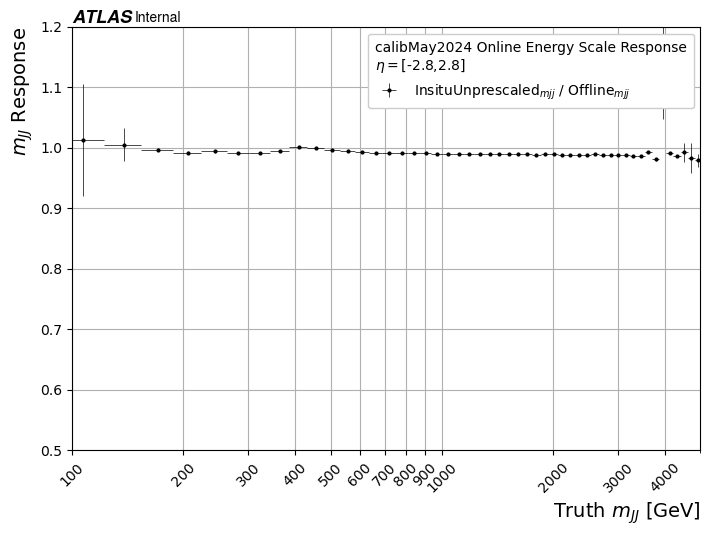

In [28]:
# Loop over the file paths
for rootFilePath in listOfRootFilePaths:
    # Loop over the slices
    for currentSlice in slices:
        # Initialize figure 185 mm wide, wiht a 800:600 widht:height ratio
        f, ax = plt.subplots(figsize=(18.3*(1/2.54), 13.875*(1/2.54)))
        
        # Define a path and name for the dataframe based on the slice range
        dfPath = "TestDataFrameForPlotting_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        df = pd.read_pickle(dfPath+".pickle") # Read the appropriate dataframe. One per slice, per file path
        
        # Get data information based on root file path and TH3 name
        DataOrMC = isItDataOrMC(rootFilePath)
        OnlineOrOffline = isItOnlineOrOffline(df.index[0])
        campagin = rootFilePath.split("/")[-1].split(".")[0].split("_")[1]
        
        # Define markers and colors for plot data series
        markers = ["o","^",">","v","<"]
        colors = ["black","crimson","darkorange","dodgerblue","forestgreen"]
        i=0 # Set an iterator for the markes and colors
        
        # Iterate over TH3s in data frame, in the reverse order
        for TH3Name in reversed(df.index):
            skipping = False # Set upp skipping flag
            if xAxisUnit not in TH3Name: # Skip pT plots if we are interested in mjj. For example
                skipping = True
            # A quick loop over the list of skipped energy scales
            for skippedEnergyScales in skipEnergyScales: # Skip if the 3D histogram name is in the list to skip
                if skippedEnergyScales in TH3Name:
                    skipping = True
            if skipping: continue
                
            # Get data information based on TH3 name
            numeratorEnergyScale = TH3Name.split("_-_")[1].split("_")[0].split("-")[0]
            denominatorEnergyScale = TH3Name.split("_-_")[1].split("_")[2].split("-")[1]

            # Assign data from dataframe for the current 3D histogram name
            x=df["x"].loc[TH3Name]
            y=df["y"].loc[TH3Name]
            x_error=df["xError"].loc[TH3Name]
            y_error=df["yError"].loc[TH3Name]

            # Plot data
            ax.errorbar(x, y, yerr=y_error, xerr=x_error,
                        linestyle='None',
                        marker=markers[i],
                        color=colors[i],
                        markersize=2,
                        linewidth=0.5,
                        label=numeratorEnergyScale+"$_{"+xAxisUnit+"}$"+" / "+denominatorEnergyScale.capitalize()+"$_{"+xAxisUnit+"}$",
                       )
            i+=1 # Increment color and marker iterator

        # Add legend
        leg = ax.legend(borderpad=0.5, loc=1, ncol=2, frameon=True,facecolor="white",framealpha=1)
        leg._legend_box.align = "left"
        leg.set_title(campagin+" "+OnlineOrOffline+" "+responseLegendTitle[0]+"\n"+responseLegendTitle[1]+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]")

        # Set limits and labels
        ax.set_xlim(xLimits)
        ax.set_ylim(yLimits)

        # Set log scale
        ax.set_xscale("log")

        # Set axis labels
        ax.set_xlabel(xAxisLabel, fontsize=14, ha='right',x=1.0)
        ax.set_ylabel(yAxisLabel, fontsize=14, ha='right', y=1.0)


        # Add grid and custom tick markers
        ax.grid(True)
        tickList = [1,2,3,4,5,6,7,8,9,
        10,20,30,40,50,60,70,80,90,
        100,200,300,400,500,600,700,800,900,
        1000,2000,3000,4000,5000,6000,7000,8000,9000,
        10000]
        ax.set_xticks(tickList[tickList.index(xLimits[0]):tickList.index(xLimits[1])])
        ax.set_xticklabels(tickList[tickList.index(xLimits[0]):tickList.index(xLimits[1])])
        plt.xticks(rotation=45)

        # Add ATLAS label
        hep.atlas.text("Internal",ax=ax)

        # Use tight layout
        plt.tight_layout()
        
        # Save plot as .pdf
        f.savefig("output/"+campagin+"_"+OnlineOrOffline+"_"+xAxisUnit+"_"+"response"+"_"+"eta"+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"".pdf")

#### Bokeh

To be able to see how good the 1D response distributions are for each data point in the above plots, we create an interactive plot using bokeh. In the first half we just create a normal bokeh plot. In the second part we loop over each datapoint in the plot, and create a histogram based on the 1D histogram data saved for each datapoint in the dataframe. For these subplots we dump a JSON item into a list, which is later used for a custom hover tooltip in bokeh.

Import packages for bokeh.

In [69]:
import json
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, CustomJSHover, HoverTool
from bokeh.plotting import figure, show, output_notebook

Define one specific data series, from one slice, from one file path.

In [71]:
rootFilePath = listOfRootFilePaths[0]
TH3Name = "h_HLT_j420_-_InsituUnprescaled-Online_over_InsituUnprescaled-Offline_-_mjj_-_etaLeading"
currentSlice=[-2.8,2.8]
dfPath = "TestDataFrameForPlotting_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
df= pd.read_pickle(dfPath+".pickle")
series = df.loc[TH3Name]

Assign the data, create the bokeh data structure "source", the figure, and plot the data.

In [72]:
# Assign data from dataframe for the current 3D histogram name
x = series['x']
y = series['y']

source = ColumnDataSource(data={'x':x,'y':y})
#source = ColumnDataSource(data=dict(x=[1, 4, 8], y=[2, 8, 5]))

p = figure(plot_width=800, plot_height=600,
           x_axis_label='mjj [GeV]', y_axis_label='mjj Response',
           x_range=(100,5000),y_range=(0.97,1.01),
           x_axis_type="log",
           tools="pan,box_zoom,wheel_zoom,reset",
           tooltips=[('mjj','@x'),('Response','@y')]
          )

p.circle('x','y',source=source,legend_label=TH3Name)

GlyphRenderer(id='1035', ...)

For each data point in the plot, create a histogram from the 1D histogram data stored in the dataframe. Then dump this histogram into a json and add it into a new bokeh source.

In [73]:
listOfOut = [] # initialize an empty list ot hold histograms for each data point

# Loop over the 1D histograms / data points in the data series we are looking at
for i,TH1 in enumerate(x):
    # Initialize a bokeh figure
    p2 = figure(title="mjj = "+str(TH1)+"GeV",plot_height=400, plot_width=600, toolbar_location=None,
                x_axis_label='mjj Response [GeV]', y_axis_label='Entries',
                x_range=(0.5,1.5)
               )
    # Add a histogram based on the 1D histogram we fitted in the dataframe to the second bokeh plot
    p2.quad(top=series["TH1BinEntries"][i], bottom=0, left=series["TH1BinEdges"][i][:-1], right=series["TH1BinEdges"][i][1:],
            fill_color="navy",
            line_width=0,
           )
    # Dump the plot as a json item into the list
    listOfOut.append(json.dumps(json_item(p2, "tooltip-plot")))

# Create a bokeh data surce from the list
source.data['plot'] = listOfOut

Define some Java code and add a custom hover tooltip to the first bokeh plot.

In [74]:
# Define some Java code
code="""
    Bokeh.embed.embed_item(JSON.parse(value))
    return ""
"""

# Add a custom hover tooltip to the first bokeh plot
p.add_tools(HoverTool(
    tooltips='<div id="tooltip-plot">@plot{custom}</div>',
    formatters={ '@plot': CustomJSHover(code=code) }
))

Show the bokeh plot. Turn off the top hover tool for a better experience. The toolbar on the right should look like this:
![alt text](images/like_this.png "Title")

In [75]:
output_notebook() # Remove this if running locally to get more space for the individual 1D histograms
show(p)

Loading BokehJS ...

## Resolution - do not use this part, only check how graph overlay is done
For the resolution we want to compare the resolution of the TLA online $m_{jj}$, to the ATLAS main physics analysis' offline $m_{jj}$. Therefore we select only two of the root file paths defined in the beginning of the notebook.

In [77]:
listOfComparisonPaths = [
                listOfRootFilePaths[0],
                ]

We then select the final enegy scale and response variable, since comparing all of them would be too many, and in the end, it is the final energy scale that really matters.

In [18]:
energyScale = "GSC"
xAxisUnit = "mjj"

Next we define a function taking the form of the energy resolution of a calorimeter detector. We will use this to fit our data, since ATLAS uses a calorimeter to measure energy.

In [19]:
def resolutionFunc(x,a,b,c):
    return np.sqrt((a/np.sqrt(x))**2+(b/x)**2+c**2)

Lastly we loop over the $\eta$ slices. For each slice we loop over the root file paths which we want to compare, one with online histograms and one with offline histograms. For each file we select the 3D histogram name which corresponds to our energyscale and response variable defined above.

'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


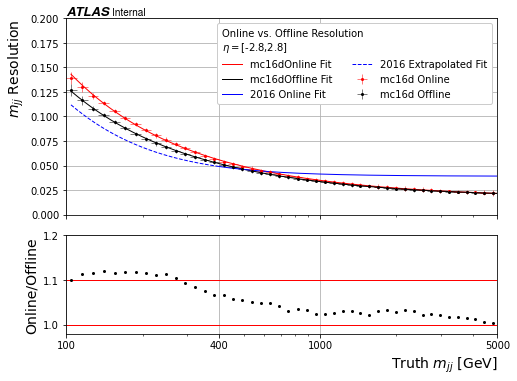

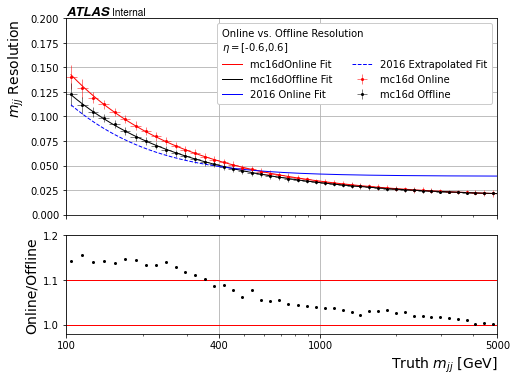

In [20]:
linspace=np.linspace(x[0],x[-1],num=10000) # Define a linspace to be used for plotting the fit
color_list=["red","black"] # Define the colors used by the two data series

# Loop over the slices
for currentSlice in slices:
    # Initialize figure 185 mm wide, wiht a 800:600 widht:height ratio
    f, axisList = plt.subplots(2,1,figsize=(18.3*(1/2.54), 13.875*(1/2.54)),sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    # Initialize empty lists of lists to hold the two data series.
    # This is later used for a ratio plot
    x_list = []
    y_list = []
    
    # Loop over the two file paths
    for i,rootFilePath in enumerate(listOfComparisonPaths):
        # Define a path and name for the dataframe based on the slice range
        dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        df= pd.read_pickle(dfPath+".pickle") # Read the appropriate dataframe. One per slice, per file path
        
        # Get data information based on root file path and TH3 name
        DataOrMC = isItDataOrMC(rootFilePath)
        OnlineOrOffline = isItOnlineOrOffline(df.index[0])

        # Only select the data series / 3D histogram following our earlier specifications
        TH3Name = df[[((energyScale in s) and (xAxisUnit in s)) for s in df.index]].index[0]
        
        # Assign data from data series
        x=df["x"].loc[TH3Name]
        x_list.append(x) # Append list for the ratio plot
        y=df["sigmaOverY"].loc[TH3Name] # The resolution is defined as the error of the response fit mean over the response mean
        y_list.append(y) # Append list for the ratio plot
        x_error=df["xError"].loc[TH3Name]
        y_error=df["sigmaOverYError"].loc[TH3Name]

        # Plot the resolution
        axisList[0].errorbar(x, y, yerr=y_error, xerr=x_error,
                    linestyle='None',
                    marker="o",
                    color=color_list[i],
                    markersize=2,
                    linewidth=0.5,
                    label=rootFilePath.split("/")[-1].split("_")[1]+" "+OnlineOrOffline)

        # Fit the resolution with the resolution function
        popt_resolutionFunc, pcov_resolutionFunc = curve_fit(resolutionFunc, x, y, sigma=y_error)

        # Plot the fit
        axisList[0].plot(linspace, resolutionFunc(linspace,*popt_resolutionFunc), lw=1, label=rootFilePath.split("/")[-1].split("_")[1]+OnlineOrOffline+" Fit",color=color_list[i])

    # Add the fit from 2016 Online resolution
    axisList[0].plot(linspace[240:], resolutionFunc(linspace[240:],0.27,10.6,0.039), lw=1, label=r'2016 Online Fit',color="blue")
    axisList[0].plot(linspace[:240], resolutionFunc(linspace[:240],0.27,10.6,0.039), lw=1, label=r'2016 Extrapolated Fit',color="blue",linestyle='dashed')

    # Legend
    leg = axisList[0].legend(borderpad=0.5, frameon=True, loc=1,ncol=2,facecolor="white",framealpha=1.0)
    leg.set_title(resolutionLegendTitle[0]+"\n"+resolutionLegendTitle[1]+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]")
    leg._legend_box.align = "left"

    axisList[0].set_ylabel(r'$m_{jj}$ Resolution', fontsize=14, ha='right', y=1.0)
    
    hep.atlas.text("Simulation Internal",ax=ax)

    # Set limits and labels of the top plot
    axisList[0].set_xlim(100,5000)
    axisList[0].set_xscale("log")
    axisList[0].set_ylim(0.00,0.2)
    axisList[0].grid()

    # Plot the ratio of Online resolution over Offline resolution
    axisList[1].errorbar(np.array(x_list[0]),np.array(y_list[0])/np.array(y_list[1]),linestyle='None',marker="o",color="black",markersize=2,linewidth=0.5,label="Ratio")

    # Set limits and grid to the ratio plot
    axisList[1].set_ylim(0.98,1.2)
    axisList[1].grid()
    
    # Add 10% graphic lines
    axisList[1].plot( [100,5000], [1.0,1.0],color="red",lw=1)
    axisList[1].plot( [100,5000], [1.1,1.1],color="red",lw=1)

    # Add custom tick markers
    axisList[1].set_axisbelow(True)
    axisList[1].set_xticks([100,400,1000,5000])
    axisList[1].set_xticklabels([100,400,1000,5000])

    # Add axis labels
    axisList[1].set_xlabel(r"Truth $m_{jj}$ [GeV]", fontsize=14, ha='right', x=1.0)
    axisList[1].set_ylabel(r"Online/Offline", fontsize=14)

    # Add ATLAS label
    hep.atlas.text("Internal",ax=axisList[0])
    
    # Use tight layout
    plt.tight_layout()
    
    # Save plot as .pdf
    f.savefig("output/"+rootFilePath.split("/")[-1].split("_")[1]+"_"+"onlineVsOffline"+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"+".pdf")

## Resolution Based Binning - not needed either
We will use the resolution to estimate the resolution of the detector, and with that obtain the optimal $m_{jj}$ histogram binning. Firstly we define the same resolution function as before.

In [21]:
def resolutionFunc(x,a,b,c):
    return np.sqrt((a/np.sqrt(x))**2+(b/x)**2+c**2)

Next we pick the data series we want to use for obtaining the new binning. For this we want to use the highest energy scale, GSC, the large $\eta$ slice -2.8 to 2.8, from the mc16d Online filepath.

In [22]:
rootFilePath = listOfRootFilePaths[0]
TH3Name = "scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta"
currentSlice=[-2.8,2.8]
dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
df= pd.read_pickle(dfPath+".pickle")

Next we assign variables to the appropriate lists of the dataframe and fit this data with a resolution function.

In [23]:
x=df["x"].loc[TH3Name]
y=df["sigmaOverY"].loc[TH3Name]
x_error=df["xError"].loc[TH3Name]
y_error=df["sigmaOverYError"].loc[TH3Name]

popt_resolutionFunc, pcov_resolutionFunc = curve_fit(resolutionFunc, x, y, sigma=y_error)

We want at least one bin edge to be at 531 GeV, since this bin edge coincides with previous studies. We therefore start at 531 and loop down to 100. For each iteration we define a bin width as the rounded integer of the resolution function evaluated at the current bin edge, times the current bin edge. The next iteration starts from the first bin edge minus the calculated bin width, and so on.

In [24]:
bins1 = [] # Initialize an empty list to hold the bottom half of the list of bin edges
currentEdge = 531 # Define the starting bind edge

# Loop until the bin edge is less than 100
while (currentEdge > 100):
    # Calculate a new bin width by evaluating the resolution fit at the current edge
    currentBinwidth = int(round( resolutionFunc(currentEdge, *popt_resolutionFunc)*currentEdge ))
    currentEdge -= currentBinwidth # Define a new current edge by subtraction
    bins1.append(currentEdge) # Append the new current edge


We then do the same but in reverse from 531 up to 5000. For each evaluated bin width we add that bin width to the current bin edge instead of subtracting.

In [25]:
bins2 = [] # Initialize an empty list to hold the top half of the list of bin edges
currentEdge = 531# Define the starting bind edge

# Loop until the bin edge is less than 100
while (currentEdge < 5000):
    # Calculate a new bin width by evaluating the resolution fit at the current edge
    currentBinwidth = int(round( resolutionFunc(currentEdge, *popt_resolutionFunc)*currentEdge ))
    currentEdge += currentBinwidth # Define a new current edge by addition
    bins2.append(currentEdge) # Append the new current edge

Merge the two list of bin edges, append the starting bin edge, and sort the list in ascending order.

In [26]:
bins=bins1+bins2
bins.append(531)
bins.sort()

print("Bin edges: \n",bins)

Bin edges: 
 [92, 107, 122, 138, 154, 171, 188, 206, 224, 243, 262, 282, 302, 322, 343, 365, 387, 410, 433, 457, 481, 506, 531, 556, 582, 608, 635, 662, 690, 719, 748, 778, 808, 839, 871, 903, 936, 970, 1004, 1039, 1075, 1111, 1148, 1186, 1225, 1264, 1304, 1345, 1387, 1429, 1472, 1516, 1561, 1607, 1654, 1702, 1750, 1799, 1849, 1900, 1952, 2005, 2059, 2114, 2170, 2227, 2285, 2344, 2404, 2465, 2528, 2592, 2657, 2723, 2790, 2858, 2928, 2999, 3071, 3145, 3220, 3296, 3374, 3453, 3533, 3615, 3698, 3783, 3869, 3957, 4046, 4137, 4230, 4324, 4420, 4518, 4617, 4718, 4821, 4926, 5033]


Next we write the binning to a JSON file for easy sharing.

In [27]:
import json
# Create a dictionary of different types of binning, one containing our binning
mjjBins = {
    'TLAdefault':   bins,
    'TLAlowMu'  :   []
}

outfile = open('output/mjjBins.json','w') # Open a JSON file
# Write the dictionary to the JSON file
outfile.write(json.dumps(mjjBins, sort_keys=True, indent=4, separators=(',', ': ')))
outfile.close()

This JSON file of bin edges will be stored centrally and provide a optimal binning for the whole analysis team to use.